In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns
import random

from models import *
from utils import *
from train import *
from bvc import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class RectangleEnvironment:
    '''
    Rectangular environment to obtain BVC and PC firing rates
    '''
    def __init__(self, l, w):
        self.l = torch.Tensor([l]) # maximum length
        self.w = torch.Tensor([w]) # maximum width
        self.aspect_ratio = l / w
        
    def compute_wall_dist(self, loc, n_disc=360):
        '''
        Discretises bearing to 360 and compute the distance to each segment
        (0,0) is the bottom left corner, north is 0 bearing
        '''
        x, y = loc
        x = torch.Tensor([x]) if not isinstance(x, torch.Tensor) else x
        y = torch.Tensor([y]) if not isinstance(y, torch.Tensor) else y
        assert torch.any(x) > 0 and torch.any(x) < self.l
        assert torch.any(y) > 0 and torch.any(y) < self.w
        try:
            n_mesh_x, n_mesh_y = x.shape
        except:
            n_mesh_x, n_mesh_y = 1, 1
        
        distances = torch.zeros(n_mesh_x, n_mesh_y, n_disc)
        
        angles = torch.ones(n_disc) * 2 *torch.pi / n_disc
        bearings = torch.linspace(0, 2*torch.pi, n_disc)
        
        # compute bearings to 4 corners
        top_right = torch.arctan((self.l-x)/(self.w-y))
        bottom_right = 1/2 * torch.pi + torch.arctan(y/(self.l-x))
        bottom_left = torch.pi + torch.arctan(x/y)
        top_left = 3/2*torch.pi + torch.arctan((self.w-y)/x)
        
        for bearing in range(n_disc):
            b = torch.Tensor([2 * torch.pi/n_disc * bearing]) # bearing in rad
            
            segment_in_top_mask = torch.logical_or(b >= top_left, b < top_right)
            segment_in_right_mask = torch.logical_and(b >= top_right, b < bottom_right)
            segment_in_bottom_mask = torch.logical_and(b >= bottom_right, b < bottom_left)
            segment_in_left_mask = torch.logical_and(b >= bottom_left, b < top_left)
            
            assert torch.all(segment_in_top_mask*1 + segment_in_right_mask*1 + segment_in_bottom_mask*1 + segment_in_left_mask*1 == torch.ones(n_mesh_x, n_mesh_y))
            
            distances[:, :, bearing] += torch.multiply(segment_in_top_mask, (self.w-y)/torch.cos(b))
            distances[:, :, bearing] += torch.multiply(segment_in_right_mask, (self.l-x)/torch.cos(b- 1/2*torch.pi))
            distances[:, :, bearing] += torch.multiply(segment_in_bottom_mask, y/torch.cos(b - torch.pi))
            distances[:, :, bearing] += torch.multiply(segment_in_left_mask, x/torch.cos(b- 3/2 * torch.pi))
        
        return distances, bearings, angles
    
    def visualise_bvc_firing_rates(self, bvcs, n=100):
        '''
        Visualises firing rate of BVC(s)
        '''
        if not isinstance(bvcs, list):
            bvcs = [bvcs]
        n_bvcs = len(bvcs)
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, n),
            torch.linspace(1e-3, self.w.item()-1e-3, n))
        distances, bearings, angles = self.compute_wall_dist((x,y))
        
        plt.figure(figsize=(6*n_bvcs, 6/self.aspect_ratio))
        firing_rates = [cell.compute_BVC_firing(distances, bearings, angles) for cell in bvcs]
        
        for i, bvc in enumerate(bvcs):
            plt.subplot(1, n_bvcs, i+1)
            plt.scatter(x, y, c= firing_rates[i])
            plt.title(f'd = {int(bvc.d)}, deg = {int(bvc.phi/torch.pi*180)}')
        plt.show()
        
        
    def visualise_pc_firing_rates(self, pcs, n=100):
        '''
        Visualises firing rate of PC(s)
        '''
        if not isinstance(pcs, list):
            pcs = [pcs]
        n_pcs = len(pcs)
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, n),
            torch.linspace(1e-3, self.w.item()-1e-3, n))
        distances, bearings, angles = self.compute_wall_dist((x,y))
        
        plt.figure(figsize=(6*n_pcs, 6/self.aspect_ratio))
        firing_rates = [cell.compute_PC_firing(distances, bearings, angles) for cell in pcs]
        
        for i, pc in enumerate(pcs):
            plt.subplot(1, n_pcs, i+1)
            plt.scatter(x, y, c=firing_rates[i])
            plt.title(f'Place cell {i+1}/{n_pcs}')
            plt.colorbar()
        plt.show()

In [94]:
class BoundaryVectorCell:
    '''
    A boundary vector cell initiliased with preferred distance (mm) and angle (rad)
    '''
    def __init__(self, d, phi, sigma_zero=600, beta=1830, sigma_ang=0.2, multiplier=1, maxfire=False) -> None:
        self.d = torch.Tensor([d])
        self.phi = torch.Tensor([phi])
        self.sigma_zero = sigma_zero                                                 # Hartley 2000: sigZero = 122 mm
        self.beta = beta                                                             # Hartley 2000: beta = 1830 mm
        self.sigma_ang = torch.Tensor([sigma_ang])                                   # Hartley 2000: angSig = 0.2 rad
        self.sigma_rad = torch.Tensor([((self.d/self.beta)+1) * self.sigma_zero])    # Hartley 2000: sigma_rad = [(d/beta) + 1] * sigma_zero
        self.multiplier = multiplier
        self.maxfire = maxfire

    def compute_BVC_firing_single_segment(self, r, theta):
        '''
        Computes the firing of BVC given a current distance and angle to a single segment.
        Firing rate is proportional to product of two gaussians centerred at the preferred distance and angle
        Vectorised: r and theta can be arrays or matrices
        
        :param r:       animal's allocentric distance to boundary
        :param theta:   animal's allocentric bearing to boundary
        '''
        unscaled_firing_rate = torch.exp(-(r - self.d) ** 2 / (2 * self.sigma_rad ** 2))/ \
                torch.sqrt(2 * torch.pi * self.sigma_rad ** 2) * \
                    torch.exp(-(theta - self.phi) ** 2 / (2 * self.sigma_ang ** 2))/ \
                        torch.sqrt(2 * torch.pi * self.sigma_ang ** 2)
        
        return unscaled_firing_rate
    
    def compute_BVC_firing(self, distances, bearings, angles):
        '''
        A section of wall at distance r, bearing theta, subtending a angle dtheta at the rat contributes
        dfi = gi(r, theta) * dtheta
        The firing rate is found by integrating to find the net contribution of all the environment's boundaries
        '''
        n_disc = distances.shape[-1]
        
        unscaled_firing_rates = torch.stack([self.compute_BVC_firing_single_segment(distances[:,:,i], bearings[i]) for i in range(n_disc)], dim=-1)
        firing_rates = self.multiplier * torch.sum(torch.multiply(unscaled_firing_rates, angles), dim=-1)
        
        if self.maxfire is not False:
            return torch.clamp(firing_rates, min=None, max=self.maxfire)
        else:
            return firing_rates

In [95]:
def plot_bvc_firing_field(bvcs, max_d='auto', n=200):
    '''
    Plots firing field of (multiple) BVCs
    '''
    if not isinstance(bvcs, list):
        bvcs = [bvcs]
    n_bvcs = len(bvcs)
    
    if max_d =='auto':
        max_d = int(max([i.d for i in bvcs]) * 1.5)
    rads = torch.linspace(0, 2*torch.pi, n)
    ds = torch.linspace(0, max_d, n)

    rads_mat, ds_mat = torch.meshgrid(rads, ds)

    plt.figure(figsize=(4*n_bvcs, 4))
    for i in range(n_bvcs):
        ax = plt.subplot(1, n_bvcs,i+1, projection='polar')
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0)
        firing_rates = bvcs[i].compute_BVC_firing_single_segment(ds_mat, rads_mat)
        ax.scatter(rads_mat, ds_mat, c=firing_rates, s=1, cmap='hsv', alpha=0.75)
    plt.show()

In [96]:
class PlaceCell:
    '''
    A place cell receives input from multiple boundary vector cells
    The firing F_j(x) of PC j at location x is proportional to the thresholded, weighted sum of the N BVC sets that connect to it
    Output is the thresholded firing sum, each at the same allocentric reference frame, scaled by a coefficient A
    '''
    def __init__(self, bvcs=False, connection_weights=False, non_linearity=nn.ReLU(), A=10000, T=False, max_fire=False):
        
        if bvcs is not False:
            self.bvcs = bvcs
            self.n_bvcs = len(self.bvcs)
            self.connection_weights = connection_weights
            assert len(self.connection_weights) == len(self.bvcs)
            
        self.T = T
        self.non_linearity = nn.ReLU()
        self.A = A
        self.max_fire = max_fire
    
    def create_random_bvcs(self, n_bvcs, max_r=1000):
        self.n_bvcs = n_bvcs
        
        rs = dist.Uniform(low=0, high=max_r).sample(sample_shape=torch.Size([n_bvcs]))
        phis = dist.Uniform(0, 2*torch.pi).sample(sample_shape=torch.Size([n_bvcs]))
        
        self.bvcs = [BoundaryVectorCell(rs[i], phis[i]) for i in range(n_bvcs)]
        self.connection_weights = torch.ones(n_bvcs)
        
    def compute_PC_firing(self, distances, bearings, subtended_angles):
        try:
            self.bvcs
        except:
            raise AttributeError('No BVCs initialised')
            
        bvc_firing_rates = torch.stack([bvc.compute_BVC_firing(distances, bearings, subtended_angles) for bvc in self.bvcs], dim=-1)
        weighted_sum = torch.sum(torch.mul(bvc_firing_rates, self.connection_weights), dim=-1)
        
        thresholded_sum = self.A * weighted_sum
        
        if self.T == False:
            self.T = 0.9 * torch.max(thresholded_sum)
            
        thresholded_sum = thresholded_sum - self.T
        
        if self.max_fire is False:
            return self.non_linearity(thresholded_sum)
        else:
            return torch.clamp(self.non_linearity(thresholded_sum), min=None, max=self.max_fire)
    
    def BCM_weight_update(self, PC_firing, BVC_firings, D=0.2, F0=0.3, p=3, Phi=lambda F, xi: nn.Tanh(F*(F-xi))):
        '''
        Sustained firing of post-synatic cell below a dynamic threshold leads to weakening of the connection from the pre-synaptic cell
        and vice versa.
        Magnitude of change between PC and BVC i is dw = D(f_i(x) Phi(Fj(x), xi)), xi = (<Fj>/F0)^p*<Fj>
        '''
        Fj = torch.mean(PC_firing)
        xi = torch.pow((Fj/F0), p) * Fj
        dW = [D * BVC_firings[i] *Phi(PC_firing, xi) for i in range(self.n_bvcs)]
        
        return dW

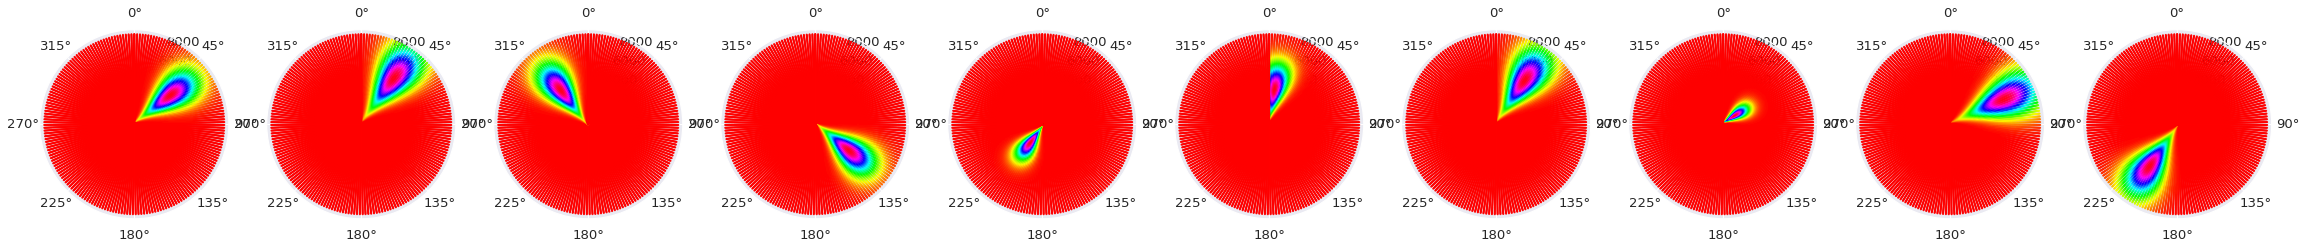

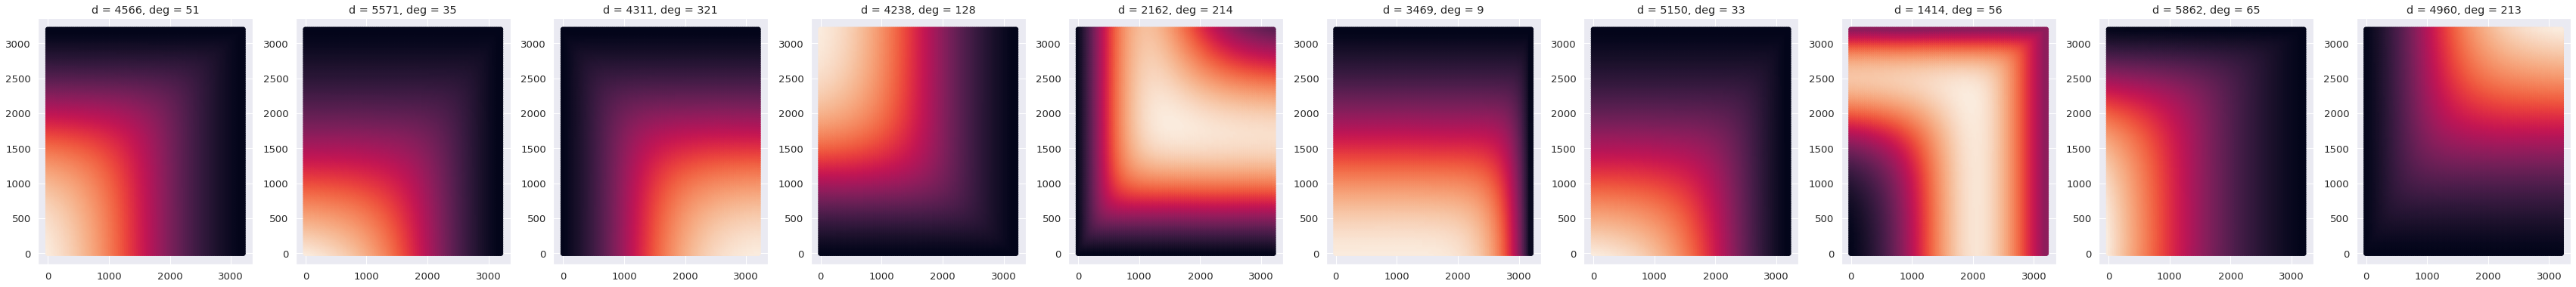

In [109]:
# simute BVCs to feed into a place cell
l = 3200
w = 3200
n_BVCs = 10
env = RectangleEnvironment(l, w)
connection_weights = torch.ones(n_BVCs)
dists = dist.Uniform(0,6400).sample(sample_shape=torch.Size([n_BVCs]))
preferred_angle= dist.Uniform(0, 2*torch.pi).sample(sample_shape=torch.Size([n_BVCs]))

BVCs = [BoundaryVectorCell(dists[i], preferred_angle[i]) for i in range(len(dists))]
plot_bvc_firing_field(BVCs[:10], max_d='auto')
env.visualise_bvc_firing_rates(BVCs)

/tmp/ipykernel_6721/232467117.py:96: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


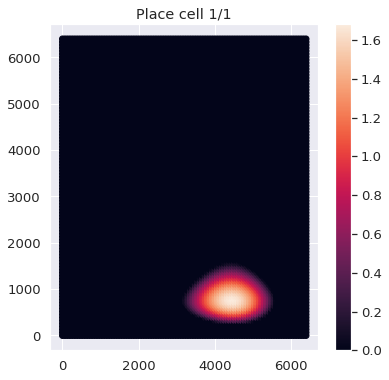

In [105]:
PC1 = PlaceCell(bvcs=BVCs, connection_weights=torch.ones(len(BVCs)))
env.visualise_pc_firing_rates(PC1)

/tmp/ipykernel_6721/232467117.py:96: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


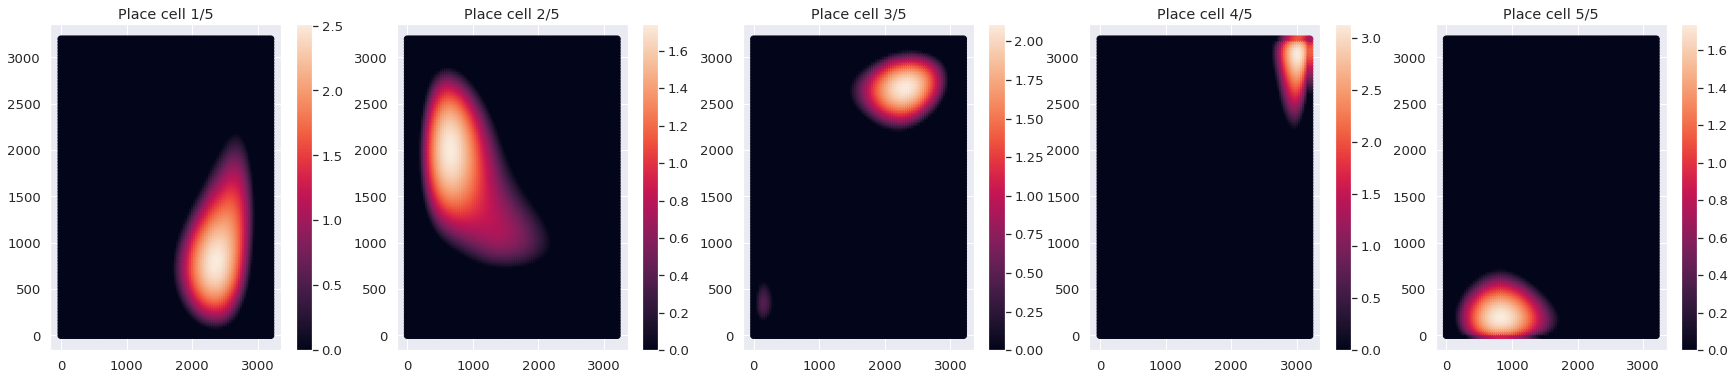

In [ ]:
PlaceCells = []
for i in range(5):
    PC = PlaceCell()
    PC.create_random_bvcs(n_bvcs=10, max_r=6400)
    PlaceCells.append(PC)
env.visualise_pc_firing_rates(PlaceCells)

In [ ]:
class Agent:
    def __init__(self, env):
        # assumes rectangular environment
        self.env_l = env.l
        self.env_w = env.w
        self.x0 = dist.Uniform(low=torch.zeros(2), high=torch.concat((env.l, env.w))).sample() # initial position
        self.loc = self.x0.clone()
    
    def step(self):
        # updates the location according to a diffusion process
        prop_loc = self.loc + diffusion(self.loc, dt, diff_coeff)
        
        # check if outside boundary
        
        

In [1]:
# simulate 100 BVCs and 10 PCs each connected to 10 random BVCs
class BVCNetwork:
    def __init__(self, BVCs, 